In [ ]:
Ŕ# Copyright 2022 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Symantic Segmentation of High Resolution Imagery
Author: Mort Canty


## Context
 
[Fully convolutional neural networks](https://ieeexplore.ieee.org/document/7478072) (FCNs) are commonly used for [semantic image classification or segmentation](https://nanonets.com/blog/semantic-image-segmentation-2020/), essentially the assignment of every pixel in an image to one of two or more categories. In this tutorial we examine a popular FCN architecture, called [UNet](https://arxiv.org/abs/1505.04597) to perform a specific semantic segmentation task, namely urban building recognition: the identification within an arbitrarily complex remote sensing image of houses, schools, commercial edifices, etc. Here for example is a recent application of the UNet architecture for large scale [semantic classification of building footprints](https://arxiv.org/abs/2107.12283) over the entire African continent.  

To train our model we will make use of the sematic labels dataset  for the [INRIA Aerial Imaging Labeling Benchmark](https://hal.inria.fr/hal-01468452/document), published in 2016. The dataset, consisting of 30cm spatial resolution images and semantic labels over built up regions in Europe and USA, can be downloaded [here](https://project.inria.fr/aerialimagelabeling/). A presentation of the most successful semantic classifiers determined in the early part of the benchmark competition is given [here](https://hal.inria.fr/hal-01767807/document). 

After uploading the labels to GEE we'll use them to generate a 1m resolution training dataset from the [GEE high resolution image archive](https://developers.google.com/earth-engine/datasets/tags/highres) and use it to train our UNet semantic classifier.

## Preliminaries

In [ ]:
# Setup the GEE Python API
import ee
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Q3uDc46Rqx5XjqmdQ3RCqgdYBLBzT1D3fPPjFHKEzwQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjtxHznbTXQNamJVfGKQw2MikbXzTaa6PXBk__zbQhEOHkCI_g2YrY

Successfully saved authorization token.


In [ ]:
# Import python modules
import os, sys
from osgeo import gdal,gdalconst
from osgeo.gdalconst import GA_ReadOnly
import numpy as np
import scipy
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
%matplotlib inline

In [ ]:
# Import the Folium library.
import folium
from folium.plugins import Fullscreen # won't work on Colab

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
# Mount Google Drive 
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# query GPU device
tf.test.gpu_device_name()

'/device:GPU:0'

## The training Dataset

For an up-to-date overview of available training datasets for classification, object recognition and semantic segmentation see [Long et al. (2020)](https://arxiv.org/abs/2006.12485). In the present case, to quote from the INRIA download site:


 >[the images] cover dissimilar urban settlements, ranging from densely populated areas (e.g., San Francisco’s financial district) to alpine towns (e.g,. Lienz in Austrian Tyrol).

The high resolution images in the GEE archive are confined to the continental USA. There are 180 image/label pairs in all in the INRIA competition dataset, but only 72 over USA cities. Here is is an example of a semantic label over Chicago after upload to GEE and projection onto a folium map. The two RGB images shown are taken at different acquisition times from the GEE's [USDA NAIP dataset](https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ).

In [ ]:
label = ee.Image('users/mortcanty/chicago_label3')

location = label.geometry().centroid().coordinates().getInfo()[::-1]
m = folium.Map(location=location, zoom_start=15, height=800, width=1000)

m.add_ee_layer(label, {'min': 0, 'max': 200}, 'INRIA Label Image')

naip2015 = ee.ImageCollection('USDA/NAIP/DOQQ') \
                      .filter(ee.Filter.date('2014-01-01', '2015-12-31')) \
                      .filterBounds(label.geometry()) \
                      .mosaic() \
                      .clip(label.geometry()) 
naip2018 = ee.ImageCollection('USDA/NAIP/DOQQ') \
                      .filter(ee.Filter.date('2017-01-01', '2018-12-31')) \
                      .filterBounds(label.geometry()) \
                      .mosaic() \
                      .clip(label.geometry()) 

naip2015_rgb = ee.Image.rgb(naip2015.select(3),naip2015.select(1),naip2015.select(2))
naip2018_rgb = ee.Image.rgb(naip2018.select(3),naip2018.select(1),naip2018.select(2))
m.add_ee_layer(naip2015_rgb, {'min': 0, 'max': 255}, '2015 NAIP Image')
m.add_ee_layer(naip2018_rgb, {'min': 0, 'max': 255}, '2018 NAIP Image')

m.add_child(folium.LayerControl())

display(m)

### The UNet FCN
We'll program here a "vanilla" UNet based on the architecture described in [de Jong et al. (2019)](https://export.arxiv.org/pdf/1812.05815v2). It consists of an encoder and decoder section with lateral connections between the two, which in the literature is usually displayed in the form of a "U". The encoder section is a series of 5 pairs of Conv2D convolutional layers, with successively doubling numbers of filters (64, 128, ...), connected by MaxPooling2D layers which successively halve the image dimensions (512, 256, ...). The decoder section reverses the process with the help of upsampling Conv2DTranspose layers, ultimately reconstructing the input image signal at the network output. The input to each upsampling layer consists of the output from the preceding layer, merged (concatenated) with the output of the corresponding Conv2d layer from the encoding section. The idea is to restore higher resolution details lost during the image compression (encoding) phase while decoding takes place. The model takes as input a four channel RGB+NIR image in _np.uint8_ format and outputs an 1-channel image in _np.float32_ format. The output of the last Conv2D layer is passed through a sigmoid activation function.

Since the convolutional layers are all identical except for the number of filters, and since each is followed by a [batch normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layer, it improves readability to use some shortcut functions. These can be conveniently programmed with the tensorflow _sequential API_:

In [ ]:
# shortcuts
def conv2d(filters):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters,3,padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu')])
def conv2dtranspose(filters):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2DTranspose(filters,3,strides=2,padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu')])
def maxpooling2d():
    return tf.keras.layers.MaxPooling2D(pool_size=2,strides=2,padding="same")

Here is the full UNet model written in tensorflow's _functional API_:

In [ ]:
# UNet
def unet_model(num_channels=4,image_size=512):    
    inputs = tf.keras.layers.Input(shape=(image_size,image_size,num_channels))
    rescaled= tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
#  coder     
    conv11 = conv2d(64)(rescaled)
    conv12 = conv2d(64)(conv11)
    max_pool1 = maxpooling2d()(conv12)
    conv21 = conv2d(128)(max_pool1)
    conv22 = conv2d(128)(conv21)
    max_pool2 = maxpooling2d()(conv22)
    conv31 = conv2d(256)(max_pool2)
    conv32 = conv2d(256)(conv31)
    max_pool3 = maxpooling2d()(conv32)
    conv41 = conv2d(512)(max_pool3)
    conv42 = conv2d(512)(conv41)
    max_pool4 = maxpooling2d()(conv42)
    conv51 = conv2d(1024)(max_pool4)
    conv52 = conv2d(1024)(conv51)
#  decoder    
    uconv51 = conv2dtranspose(512)(conv52)
    merge_dec5 = tf.keras.layers.concatenate([conv42,uconv51],axis=3)
    conv_dec_41 = conv2d(512)(merge_dec5)
    conv_dec_42 = conv2d(512)(conv_dec_41)
    uconv41 = conv2dtranspose(256)(conv_dec_42)
    merge_dec4 = tf.keras.layers.concatenate([conv32,uconv41],axis=3)
    conv_dec_31 = conv2d(256)(merge_dec4)
    conv_dec_32 = conv2d(256)(conv_dec_31)
    uconv31 = conv2dtranspose(128)(conv_dec_32)
    merge_dec3 = tf.keras.layers.concatenate([conv22,uconv31],axis=3)
    conv_dec_21 = conv2d(128)(merge_dec3)
    conv_dec_22 = conv2d(128)(conv_dec_21)
    uconv21 = conv2dtranspose(64)(conv_dec_22)
    merge_dec2 = tf.keras.layers.concatenate([conv12,uconv21],axis=3)
    conv_dec_11 = conv2d(64)(merge_dec2)
    conv_dec_12 = conv2d(64)(conv_dec_11)
#  output    
    conv_dec_12 = conv2d(8)(conv_dec_12)
    output = tf.keras.layers.Conv2D(1,1,activation = 'sigmoid')(conv_dec_12)
    return tf.keras.Model(inputs = inputs, outputs = output)

In [ ]:
model = None
model = unet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 4  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 4)  0           ['input_1[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 512, 512, 64  2624        ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

We'll also use a standard Adam optimizer with a learning rate of 0.001 and a BinaryCrossentropy loss function corresponding to the sigmoid activation. The metric is _BinaryAccuracy()_.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

Also the following hint is useful:

In [ ]:
#Run this Javascript snippet in your browser console to prevent getting thrown out prematurely
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

### Training and test/validation data (NAIP)
Our goal is to use the UNet model to identify buildings in the NAIP aerial imagery in the GEE archive. We will train the model with NAIP subsets which match the INRIA labels over American cities, namely Austin (36 scenes) and Chicago (36 scenes). To this end the corresponding 72 label images were uploaded to GEE assets, and then the matching NAIP images (and the labels) were exported to Google Drive at a scale of 1m and with the same crs as the label images. The uploading had to be done image-for-image from the GEE asset menu. We can take advantage of the fact that the NAIP imagery is acquired repeatedly over several years, so that we can obtain repeated training examples measured at different times and with different sensors.

Here is the export script for downloading the NAIP image/label pairs for 2015. This is repeated for 2018. SInce the imagery is acquired over relatively long periods, the time windows have been set generously.

In [ ]:
start = 1
end = 36

images = ['projects/ee-mortcanty/assets/inria/austin'+str(i) for i in range(start,end+1)]
crs = 'EPSG:26914'
fnp = 'austin'

#images = ['projects/ee-mortcanty/assets/inria/chicago'+str(i) for i in range(start,end+1)]
#crs = 'EPSG:26916'
#fnp = 'chicago'

for i in range(start-1,end):
    filenameprefix = fnp+str(i+1)
    lbl = ee.Image(images[i]) # the labels
    naip = ee.ImageCollection('USDA/NAIP/DOQQ') \
                      .filter(ee.Filter.date('2013-01-01', '2015-12-31')) \
                      .filterBounds(lbl.geometry()) \
                      .mosaic() \
                      .clip(lbl.geometry()) 
    gdexport = ee.batch.Export.image.toDrive(naip,
                description='driveExportTask', 
                folder = 'Inria/naip_images_2015',
                crs = crs,                             
                fileNamePrefix=filenameprefix,scale=1,maxPixels=1e11)   
    gdexport.start()
    gdexport1 = ee.batch.Export.image.toDrive(lbl,
                description='driveExportTask', 
                folder = 'Inria/naip_labels',
                crs=crs,
                fileNamePrefix=filenameprefix,scale=1,maxPixels=1e11)   
    gdexport1.start()    


In [ ]:
start = 1
end = 36

#images = ['projects/ee-mortcanty/assets/inria/austin'+str(i) for i in range(start,end+1)]
#crs = 'EPSG:26914'
#fnp = 'austin'

images = ['projects/ee-mortcanty/assets/inria/chicago'+str(i) for i in range(start,end+1)]
crs = 'EPSG:26916'
fnp = 'chicago'

for i in range(start-1,end):
    filenameprefix = fnp+str(i+1)
    lbl = ee.Image(images[i]) # the labels
    naip = ee.ImageCollection('USDA/NAIP/DOQQ') \
                      .filter(ee.Filter.date('2017-01-01', '2018-12-31')) \
                      .filterBounds(lbl.geometry()) \
                      .mosaic() \
                      .clip(lbl.geometry()) 
    gdexport = ee.batch.Export.image.toDrive(naip,
                description='driveExportTask', 
                folder = 'Inria/naip_images_2018',
                crs = crs,                             
                fileNamePrefix=filenameprefix,scale=1,maxPixels=1e11)   
    gdexport.start()
    

In [ ]:
train_folder = '/content/drive/MyDrive/Inria'

Now the 1m resolution images and their labels are on Google Drive. We next create the train/test dataset in compressed .npz format. Each image is split into four $512\times 512$ tiles. Additionally we chain the 2015 and 2017 aquisition periods (without earlier data as they may differ too much from the labels, which were created in 2016) and augment each tile with a 2% linear stretch and histogram equalization. These are so-called *regularization* measures which, it is hoped, will prevent overfitting and improve generalization.  

In [ ]:
def bytestretch(arr,rng=None):
#   byte stretch image numpy array
    shp = arr.shape
    arr = arr.ravel()
    if rng is None:
        rng = [np.min(arr),np.max(arr)]
    tmp =  (arr-rng[0])*255.0/(rng[1]-rng[0])
    tmp = np.where(tmp<0,0,tmp)  
    tmp = np.where(tmp>255,255,tmp) 
    return np.asarray(np.reshape(tmp,shp),np.uint8)

def histeqstr(x):
#   histogram equalization stretch        
    x = bytestretch(x)
    hist,bin_edges = np.histogram(x,256,(0,256))
    cdf = hist.cumsum()
    lut = 255*cdf/float(cdf[-1])
    return np.interp(x,bin_edges[:-1],lut)

def lin2pcstr(x):
#  2% linear stretch
    x = bytestretch(x)
    hist,bin_edges = np.histogram(x,256,(0,256))
    cdf = hist.cumsum()
    lower = 0
    i = 0
    while cdf[i] < 0.02*cdf[-1]:
        lower += 1
        i += 1
    upper = 255
    i = 255
    while (cdf[i] > 0.98*cdf[-1]) and (upper>100):
        upper -= 1
        i -= 1
    fp = (bin_edges-lower)*255/(upper-lower)
    fp = np.where(bin_edges<=lower,0,fp)
    fp = np.where(bin_edges>=upper,255,fp)
    return np.interp(x,bin_edges,fp)          
    
def make_traintest_arrays_naip(folder):
    from osgeo.gdalconst import GA_ReadOnly

    gdal.AllRegister()
    
#  images
    files = os.listdir(folder+'/naip_images_2015')
    files.sort()
    num_files = len(files)
    idx = np.random.permutation(range(24*num_files)) 
    images = np.zeros((24*num_files,512,512,4),dtype=np.uint8)
    i = 0
    print('images array 2015:')
    for file in files:
        if i%10 == 0:
            print( '%i '%i,end=' ')         
        img = np.zeros((1024,1024,4),dtype=np.uint8)      
        inDataset = gdal.Open(folder+'/naip_images_2015/'+file, GA_ReadOnly)
        for b in range(4):
            band = inDataset.GetRasterBand(b+1)
            img[:,:,b] = band.ReadAsArray(0,0,1024,1024)        
        images[i,:,:,:] =   img[:512,:512,:]
        images[i+1,:,:,:] = img[:512,512:,:]
        images[i+2,:,:,:] = img[512:,:512,:]
        images[i+3,:,:,:] = img[512:,512:,:]   
#      augmentation linear saturation stretch 
        img2pc = img*0
        for k in range(4):
            img2pc[:,:,k] = lin2pcstr(img[:,:,k])
        images[i+4,:,:,:] = img2pc[:512,:512,:]
        images[i+5,:,:,:] = img2pc[:512,512:,:]
        images[i+6,:,:,:] = img2pc[512:,:512,:]
        images[i+7,:,:,:] = img2pc[512:,512:,:]
#      augmentation histogram equalization stretch        
        imgheq = img*0
        for k in range(4):
            imgheq[:,:,k] = histeqstr(img[:,:,k])
        images[i+8,:,:,:] = imgheq[:512,:512,:]
        images[i+9,:,:,:] = imgheq[:512,512:,:]
        images[i+10,:,:,:] = imgheq[512:,:512,:]
        images[i+11,:,:,:] = imgheq[512:,512:,:] 
        i += 12       
    print('\nimages array 2018:')    
    files = os.listdir(folder+'/naip_images_2018')
    files.sort()
    for file in files:
        if i%10 == 0:
            print( '%i '%i,end=' ')          
        inDataset = gdal.Open(folder+'/naip_images_2018/'+file, GA_ReadOnly)
        for b in range(4):
            band = inDataset.GetRasterBand(b+1)
            img[:,:,b] = band.ReadAsArray(0,0,1024,1024)
        images[i,:,:,:] = img[:512,:512,:]
        images[i+1,:,:,:] = img[:512,512:,:]
        images[i+2,:,:,:] = img[512:,:512,:]
        images[i+3,:,:,:] = img[512:,512:,:]
#      augmentation linear saturation stretch 
        img2pc = img*0
        for k in range(4):
            img2pc[:,:,k] = lin2pcstr(img[:,:,k])
        images[i+4,:,:,:] = img2pc[:512,:512,:]
        images[i+5,:,:,:] = img2pc[:512,512:,:]
        images[i+6,:,:,:] = img2pc[512:,:512,:]
        images[i+7,:,:,:] = img2pc[512:,512:,:]
#      augmentation histogram equalization stretch        
        imgheq = img*0
        for k in range(4):
            imgheq[:,:,k] = histeqstr(img[:,:,k])
        images[i+8,:,:,:] = imgheq[:512,:512,:]
        images[i+9,:,:,:] = imgheq[:512,512:,:]
        images[i+10,:,:,:] = imgheq[512:,:512,:]
        images[i+11,:,:,:] = imgheq[512:,512:,:] 
        i += 12          
#  shuffle        
    images = images[idx,:,:,:]    
    
#  labels    
    files = os.listdir(folder+'/naip_labels')
    files.sort()
    labels = np.zeros((12*num_files,512,512,1),dtype=np.float32)
    i = 0
    print('\nlabels array:')
    for file in files: 
        if i%10 == 0:
            print( '%i '%i,end=' ') 
        inDataset = gdal.Open(folder+'/naip_labels/'+file, GA_ReadOnly)                              
        band = inDataset.GetRasterBand(1)
        img = np.reshape(band.ReadAsArray(0,0,1024,1024),(1024,1024,1))
        img = np.where(img>200,1,0)       
        labels[i,:,:,:] =   img[:512,:512,:]
        labels[i+1,:,:,:] = img[:512,512:,:]
        labels[i+2,:,:,:] = img[512:,:512,:]
        labels[i+3,:,:,:] = img[512:,512:,:]
        labels[i+4,:,:,:] =  img[:512,:512,:]
        labels[i+5,:,:,:] = img[:512,512:,:]
        labels[i+6,:,:,:] = img[512:,:512,:]
        labels[i+7,:,:,:] = img[512:,512:,:]
        labels[i+8,:,:,:] = img[:512,:512,:]
        labels[i+9,:,:,:] = img[:512,512:,:]
        labels[i+10,:,:,:] = img[512:,:512,:]
        labels[i+11,:,:,:] = img[512:,512:,:]
        i += 12
    labels = np.concatenate((labels,labels))
#  shuffle        
    labels = labels[idx,:,:,:]   
#  split off test data 
    split = 24*num_files - 400
    x_train = images[:split,:,:,:]
    y_train = labels[:split,:,:,:]
    x_test = images[split:,:,:,:]
    y_test = labels[split:,:,:,:]
#  save compressed    
    np.savez_compressed(folder+'/naip_images_train4.npz',x=x_train,y=y_train)
    np.savez_compressed(folder+'/naip_images_test4.npz',x=x_test,y=y_test)

In [ ]:
make_traintest_arrays_naip(train_folder)

images array 2015:
0  60  120  180  240  300  360  420  480  540  600  660  720  780  840  
images array 2018:
900  960  1020  1080  1140  1200  1260  1320  1380  1440  1500  1560  1620  1680  
labels array:
0  60  120  180  240  300  360  420  480  540  600  660  720  780  840  

Since the complete train/test dataset together with the model may exceed the available 16 GB of RAM available in the standard Colab GPU runtime, the train/test data are pipelined in batches of 4 with the function _tf.data.Dataset.from_generator()_: 

In [ ]:
class MakeDataset():

    def _generator(path):
        with np.load(path) as data:
            examples = data['x'] 
            labels = data['y']
            for index, example in enumerate(examples):
                yield (example,labels[index])

    def __new__(cls,path):
        return tf.data.Dataset.from_generator( cls._generator, 
                    output_signature = ( tf.TensorSpec(shape=(512,512,4),dtype=tf.uint8),
                    tf.TensorSpec(shape=(512,512,1),dtype=tf.float32) ),
                    args = (path,) ).batch(4)

In [ ]:
train_dataset = MakeDataset(train_folder+'/naip_images_train4.npz')
test_dataset = MakeDataset(train_folder+'/naip_images_test4.npz')

Here are som random training examples and their labels:

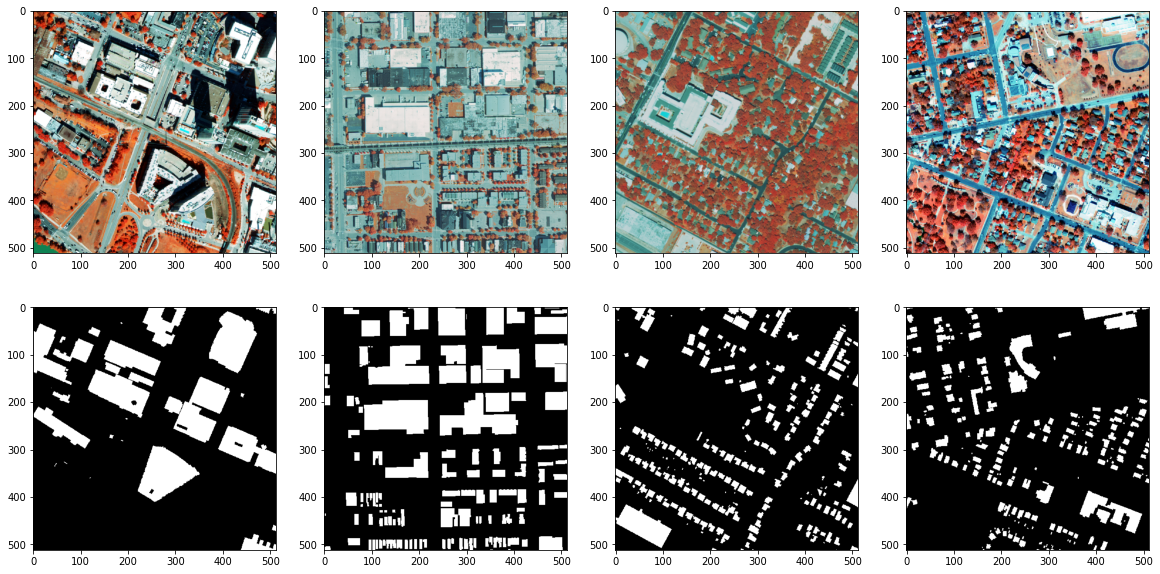

In [ ]:
train_examples, train_labels = next(train_dataset.as_numpy_iterator())
fig, ax = plt.subplots(2,4,figsize=(20,10))
for i in range(4):
    ax[0,i].imshow(train_examples[i][:,:,[3,1,2]])
    ax[1,i].imshow(np.reshape(train_labels[i],(512,512)),cmap = plt.cm.gray)
plt.show()

### Training

In [ ]:
model = keras.models.load_model(train_folder+'/unet_inria_model4.h5')

In [ ]:
model.optimizer.lr.assign(0.0003)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.0003>

In [ ]:
callback = ModelCheckpoint(train_folder+'/unet_inria_model4.h5', monitor='loss', save_best_only=True)
history = model.fit(train_dataset, epochs=10, callbacks = [callback], validation_data=test_dataset)

Epoch 1/10
332/332 [==============================] - 1484s 4s/step - loss: 0.0861 - binary_accuracy: 0.9638 - val_loss: 0.1142 - val_binary_accuracy: 0.9544
Epoch 2/10
332/332 [==============================] - 1457s 4s/step - loss: 0.0799 - binary_accuracy: 0.9663 - val_loss: 0.1110 - val_binary_accuracy: 0.9561
Epoch 3/10
332/332 [==============================] - 1456s 4s/step - loss: 0.0754 - binary_accuracy: 0.9682 - val_loss: 0.1098 - val_binary_accuracy: 0.9573
Epoch 4/10
332/332 [==============================] - 1452s 4s/step - loss: 0.0713 - binary_accuracy: 0.9699 - val_loss: 0.1087 - val_binary_accuracy: 0.9583
Epoch 5/10
332/332 [==============================] - 1452s 4s/step - loss: 0.0675 - binary_accuracy: 0.9715 - val_loss: 0.1071 - val_binary_accuracy: 0.9596
Epoch 6/10
332/332 [==============================] - 1449s 4s/step - loss: 0.0642 - binary_accuracy: 0.9729 - val_loss: 0.1044 - val_binary_accuracy: 0.9605
Epoch 7/10
332/332 [==============================] 

After training for about 25 epochs at learn rate 0.001 and 10 more at 0.0003, we evaluate on the test dataset:

In [ ]:
model.evaluate(test_dataset)

And do some visual tetsing:

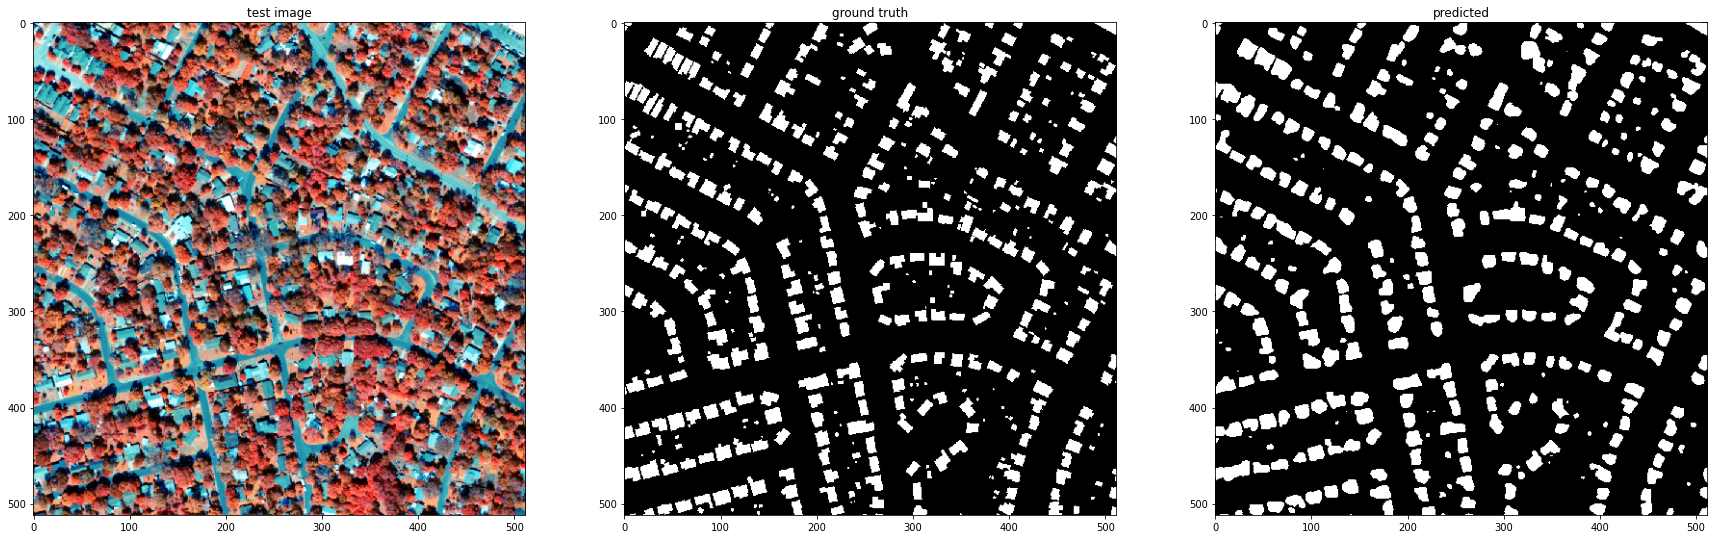

In [ ]:
k = 1 # batch
i = 0 # test example
testds = iter(test_dataset)
for j in range(k):
    test_example, test_label = next(testds)
fig, ax = plt.subplots(1,3,figsize=(30,15))
ax[0].imshow(test_example.numpy()[i][:,:,[3,1,2]])
label = np.reshape(test_label[i],(512,512))
ax[1].imshow(label,cmap = plt.cm.gray)
pred = model.predict(tf.reshape(test_example[i],(1,512,512,4)))
pred = np.reshape(np.where(pred>0.4,1,0),(512,512))
ax[2].imshow(pred,cmap = plt.cm.gray)
ax[0].set_title('test image')
ax[1].set_title('ground truth')
ax[2].set_title('predicted')
plt.show()

The comparison metric used inthe INRIA benchmark competition is _intersection over union_ (IoU), referring to the sets of labeled and classified pixels. A value of one implies perfect reproduction of the label image, a value zero means no correpondance whatsoever. The cell below calculates the average IoU for the test image/label pairs (recall that they are stored in memory in batches of 4).

In [ ]:
# IoU
i = 0
sumIoU = 0
for test_example, test_label in test_dataset:
    for j in range(4):
        label = np.reshape(test_label[j],(512,512))
        example = np.reshape(test_example[j],(1,512,512,4))
        pred = model.predict(example)
        pred = np.reshape(np.where(pred>0.4,1,0),(512,512))
        I = label*pred
        U = label+pred-I
        sU = np.sum(U)
        if sU>0: # no buildings in subscene?
            sumIoU += np.sum(I)/sU
            i += 1        
sumIoU/i

0.804613164812386

This excellent result exceeds the best results obtained by [Maggiori et al. (2017)](https://hal.inria.fr/hal-01468452/document) in the initial benchmarking of the INRIA dataset using a multi-label perceptron (MLP) architecture (0.60). The [initial winners](https://hal.inria.fr/hal-01767807/document) of the competition, achieved IoUs of the order 0.7 with variations of the UNet model that we are using here, although [later submissions](https://project.inria.fr/aerialimagelabeling/leaderboard/) reported as much as 0.8. All of the competition exercises were performed at 30cm spatial resolution, whereas we are training at 1m resolution so that a direct comparison may be misleading. 

In any case, now that we have achieved a result comparable to the best submissions to the INRIA competition lets try to classify some new data. The script _unetclassiy.py_ in the _scripts_ directory partitions an input image into $512\times 512$ tiles starting at the upper left hand corner and passes each tile through the trained model to classify it. It loads the pre-trained model and uses the model's _predict()_ function to classify the tiles. Here is the help output:

In [ ]:
%run /content/drive/MyDrive/scripts/unetclassify -h

            
Usage: 
--------------------------------------

Deep learning semantic classification of hi-res images
for building identification

python /content/drive/MyDrive/scripts/unetclassify.py [OPTIONS] filename

Options:
  -h            this help
  -m  <string>  path to stored model        
  -d  <list>    spatial subset [x,y,width,height]
  -t  <float>   probability threshold (default 0.4)
  
Classes:                   
                    0 'All background',
                    1 'Buildings',
  
Assumes rgb image bands only 
  
  -------------------------------------


<Figure size 432x288 with 0 Axes>

Here is a NAIP image exported from GEE from 2018 over the Lawrence Livermore Laboratories in California:


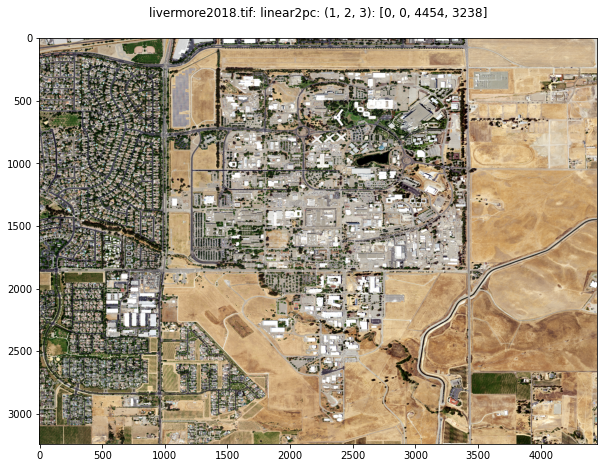

In [ ]:
%run /content/drive/MyDrive/scripts/dispms -f /content/drive/MyDrive/gee/livermore2018.tif -p [1,2,3] -e 3 

Classifying:

In [ ]:
%run /content/drive/MyDrive/scripts/unetclassify  -m /content/drive/MyDrive/Inria/unet_inria_modelxx.h5 /content/drive/MyDrive/gee/livermore2018.tif

Map written to: /content/drive/MyDrive/gee/livermore2018_cnn.tif
Elapsed time: 23.103351354599


We predict the labels:

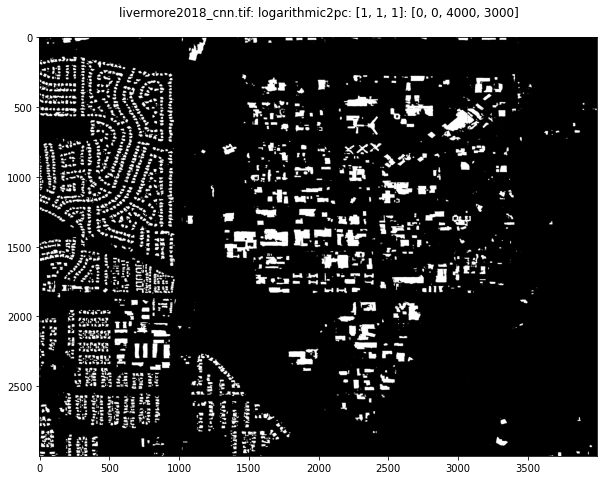

In [ ]:
%run /content/drive/MyDrive/scripts/dispms -f /content/drive/MyDrive/gee/livermore2018_cnn.tif  -d [0,0,4000,3000]

After downloading the above two images and then uploading to the EarthEngine, we can overlay them nicely (the images are shared on GEE):

In [ ]:
img = ee.Image('projects/ee-mortcanty/assets/livermore2018')
lab = ee.Image('projects/ee-mortcanty/assets/livermore2018_cnn')

location = ee.Geometry.Polygon(img.get('system:footprint').getInfo()['coordinates']).centroid().getInfo()['coordinates'][::-1]
# got to be an easier way than that!

m = folium.Map(location=location, zoom_start=14, height=800, width=1000)

m.add_ee_layer(img,{'min':0,'max':255},'NAIP')
m.add_ee_layer(lab.updateMask(lab.gt(0)),{'min':0,'max':255,'palette':['black','red']},'Label')

m.add_child(folium.LayerControl())
Fullscreen().add_to(m)

display(m)

## Conclusion

With a very straghtforward implementation of the UNet architecture we have obtained a good symantic classifier for building recognition, one which is close to state-of-the-art for the small training datasets available. We have also seen that the classifier can be applied to new RGB imagery from other sensors.